In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from fishsense_core.laser import calibrate_laser

In [2]:
# Set random seed for reproducibility
np.random.seed(0)

## Setup of Simulation
The following reasonable defaults that match the systems we tested against.

In [3]:
IMAGE_WIDTH, IMAGE_HEIGHT = 4014, 3016
FOCAL_LENGTH_PX = 2850

IMAGE_WIDTH, IMAGE_HEIGHT, FOCAL_LENGTH_PX

(4014, 3016, 2850)

In [4]:
camera_intrinsics = np.array([
    [FOCAL_LENGTH_PX, 0, IMAGE_WIDTH / 2],
    [0, FOCAL_LENGTH_PX, IMAGE_HEIGHT / 2],
    [0, 0, 1]
])
inverted_camera_intrinsics = np.linalg.inv(camera_intrinsics)

camera_intrinsics, inverted_camera_intrinsics

(array([[2.850e+03, 0.000e+00, 2.007e+03],
        [0.000e+00, 2.850e+03, 1.508e+03],
        [0.000e+00, 0.000e+00, 1.000e+00]]),
 array([[ 3.50877193e-04,  0.00000000e+00, -7.04210526e-01],
        [ 0.00000000e+00,  3.50877193e-04, -5.29122807e-01],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]))

In [5]:
laser_position = np.array([-0.04, -0.11, 0])
laser_direction = np.array([1e-10, 1e-10, 1])

laser_params = np.concatenate([laser_direction, laser_position[:2]])

laser_position, laser_direction, laser_params

(array([-0.04, -0.11,  0.  ]),
 array([1.e-10, 1.e-10, 1.e+00]),
 array([ 1.0e-10,  1.0e-10,  1.0e+00, -4.0e-02, -1.1e-01]))

## Next we setup data we can use for testing

In [6]:
STEP_COUNT = 1000
t = np.linspace(0.5, 30, STEP_COUNT)

STEP_COUNT, t

(1000,
 array([ 0.5       ,  0.52952953,  0.55905906,  0.58858859,  0.61811812,
         0.64764765,  0.67717718,  0.70670671,  0.73623624,  0.76576577,
         0.7952953 ,  0.82482482,  0.85435435,  0.88388388,  0.91341341,
         0.94294294,  0.97247247,  1.002002  ,  1.03153153,  1.06106106,
         1.09059059,  1.12012012,  1.14964965,  1.17917918,  1.20870871,
         1.23823824,  1.26776777,  1.2972973 ,  1.32682683,  1.35635636,
         1.38588589,  1.41541542,  1.44494494,  1.47447447,  1.504004  ,
         1.53353353,  1.56306306,  1.59259259,  1.62212212,  1.65165165,
         1.68118118,  1.71071071,  1.74024024,  1.76976977,  1.7992993 ,
         1.82882883,  1.85835836,  1.88788789,  1.91741742,  1.94694695,
         1.97647648,  2.00600601,  2.03553554,  2.06506507,  2.09459459,
         2.12412412,  2.15365365,  2.18318318,  2.21271271,  2.24224224,
         2.27177177,  2.3013013 ,  2.33083083,  2.36036036,  2.38988989,
         2.41941942,  2.44894895,  2.4784784

In [7]:
p = laser_position[:, np.newaxis] + t[np.newaxis, :] * laser_direction[:, np.newaxis]

p

array([[-0.04      , -0.04      , -0.04      , ..., -0.04      ,
        -0.04      , -0.04      ],
       [-0.11      , -0.11      , -0.11      , ..., -0.11      ,
        -0.11      , -0.11      ],
       [ 0.5       ,  0.52952953,  0.55905906, ..., 29.94094094,
        29.97047047, 30.        ]], shape=(3, 1000))

In [8]:
s = p / p[2, :]
s = camera_intrinsics @ s

s

array([[1.77900000e+03, 1.79171456e+03, 1.80308594e+03, ...,
        2.00319250e+03, 2.00319626e+03, 2.00320000e+03],
       [8.81000000e+02, 9.15965029e+02, 9.47236348e+02, ...,
        1.49752939e+03, 1.49753970e+03, 1.49755000e+03],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]], shape=(3, 1000))

In [9]:
s_pixel = np.round(s)

s_pixel

array([[1.779e+03, 1.792e+03, 1.803e+03, ..., 2.003e+03, 2.003e+03,
        2.003e+03],
       [8.810e+02, 9.160e+02, 9.470e+02, ..., 1.498e+03, 1.498e+03,
        1.498e+03],
       [1.000e+00, 1.000e+00, 1.000e+00, ..., 1.000e+00, 1.000e+00,
        1.000e+00]], shape=(3, 1000))

Since our laser produces a line, the projection of the laser line is itself a line in the pinhole camera model.

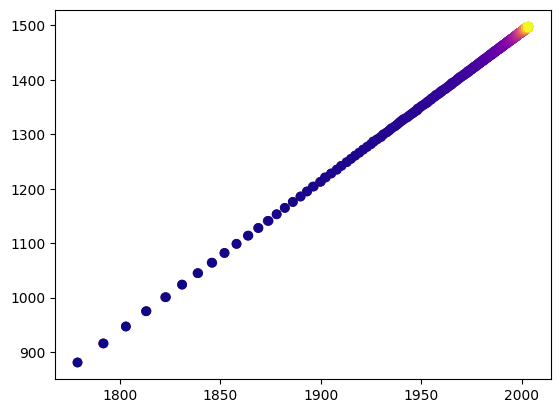

In [10]:
plt.scatter(s[0, :], s[1, :], c=p[2, :], cmap='viridis', marker='o')
plt.scatter(s_pixel[0, :], s_pixel[1, :], c=p[2, :], cmap='plasma', marker='o')

## Calibration
Below we go through calibration

In [11]:
def point_to_plane(point: np.ndarray, std: float = 0.1) -> np.ndarray:
    random_normal = np.random.normal(0, std, (3,))
    random_normal /= np.linalg.norm(random_normal)
    
    if random_normal[2] < 0:
        random_normal = -random_normal

    return point, random_normal

In [12]:
normals = []

for point in p.T:
    _, normal = point_to_plane(point)

    normals.append(normal)

normals = np.array(normals)
normals

array([[ 0.85771824,  0.1945646 ,  0.47588238],
       [-0.72840603, -0.6070528 ,  0.31766579],
       [-0.98191181,  0.15642695,  0.10667619],
       ...,
       [-0.93512886,  0.33491811,  0.11560225],
       [-0.13968815, -0.90752299,  0.39609248],
       [ 0.15638433,  0.98552139,  0.06550972]], shape=(1000, 3))

In [13]:
def atanasov_calibration_method(ps: np.ndarray):
    """
    Nikolay's method for laser calibration.
    Inputs:
     - ps: the laser points
    Output: the 5-vector of the laser parameters, with the first 3 being the orientation,
            and the final two being the x and y coordinates of the laser origin
    """
    avg_alpha = np.zeros((3,))
    params = np.zeros((5,))
    for i in range(ps.shape[0]):
        for j in range(ps.shape[0]):
            if i != j:
                v = ps[i] - ps[j]
                if v[2] < 0:
                    v = -v
                avg_alpha += v

    avg_alpha /= np.linalg.norm(avg_alpha)
    if avg_alpha[2] < 0:
        avg_alpha = -avg_alpha

    centroid = np.mean(ps, axis=0)
    print(centroid)
    scale_factor = centroid[2] / avg_alpha[2]
    params[0:3] = avg_alpha
    params[3:5] = centroid[0:2] - scale_factor * avg_alpha[0:2]
    return params

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

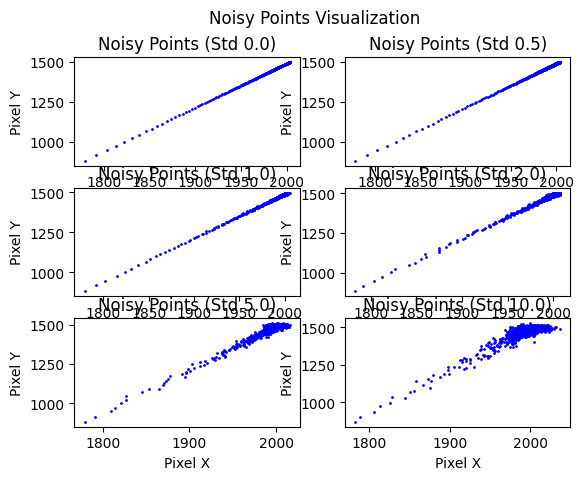

In [14]:
calibrations_by_stds = []
stds = [0.0, 0.5, 1.0, 2.0, 5.0, 10.0]

fig, axs = plt.subplots(3, 2)
fig.suptitle('Noisy Points Visualization')

for idx, std in enumerate(tqdm(stds)):
    x, y = divmod(idx, 2)
    ax = axs[x, y]

    s_noisy = np.random.normal(s, std, s.shape)
    rays = inverted_camera_intrinsics @ s_noisy
    scale_factor = np.einsum('ij,ij->j', normals.T, p) / np.einsum('ij,ij->j', normals.T, rays)
    p_noisy = rays * scale_factor

    s_pixel_noisy = np.random.normal(s_pixel, std, s_pixel.shape)
    s_pixel_noisy = np.round(s_pixel_noisy)
    rays_pixel = inverted_camera_intrinsics @ s_pixel_noisy
    scale_factor_pixel = np.einsum('ij,ij->j', normals.T, p) / np.einsum('ij,ij->j', normals.T, rays_pixel)
    p_pixel_noisy = rays_pixel * scale_factor_pixel

    calibrations = []
    calibrations_pixels = []
    for n in tqdm(list(range(2, STEP_COUNT))):
        # if n != 995:
        #     continue

        idxs = np.random.choice(np.arange(STEP_COUNT), n, replace=False)

        local_laser_origin, local_laser_orientation = calibrate_laser(p_noisy[:, idxs].T)
        calibration_noisy = np.concatenate([local_laser_orientation, local_laser_origin[:2]])

        local_laser_origin_pixel, local_laser_orientation_pixel = calibrate_laser(p_pixel_noisy[:, idxs].T)
        calibration_pixel_noisy = np.concatenate([local_laser_orientation_pixel, local_laser_origin_pixel[:2]])

        calibrations.append(calibration_noisy)
        calibrations_pixels.append(calibration_pixel_noisy)

    ax.set_title(f'Noisy Points (Std {std})')
    ax.set_xlabel('Pixel X')
    ax.set_ylabel('Pixel Y')
    ax.scatter(s_noisy[0, :], s_noisy[1, :], c='blue', s=1, label='Noisy Points')

    calibrations_by_stds.append((std, calibrations, calibrations_pixels))

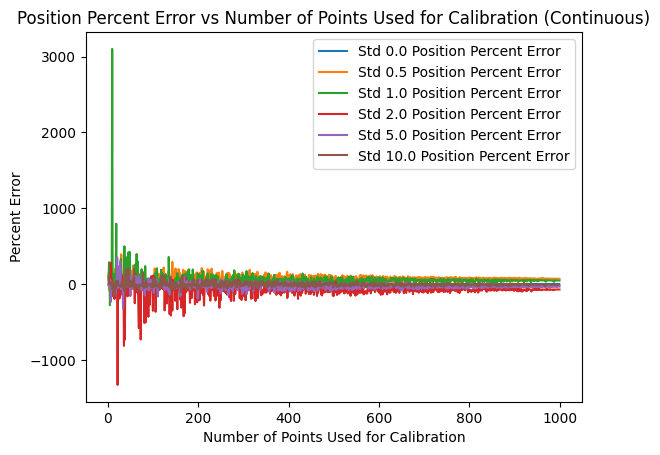

In [15]:
for std, arrays, _ in calibrations_by_stds:
    percent_error = (np.array(arrays) - np.tile(laser_params, (len(arrays), 1))) / np.tile(laser_params, (len(arrays), 1))

    direction_percent_error = percent_error[:, ][:, 0:3]
    position_percent_error = np.mean(percent_error[:, ][:, 3:5], axis=1)

    plt.plot(np.arange(2, STEP_COUNT), position_percent_error, label=f'Std {std} Position Percent Error')

plt.title('Position Percent Error vs Number of Points Used for Calibration (Continuous)')
plt.xlabel('Number of Points Used for Calibration')
plt.ylabel('Percent Error')
plt.legend()

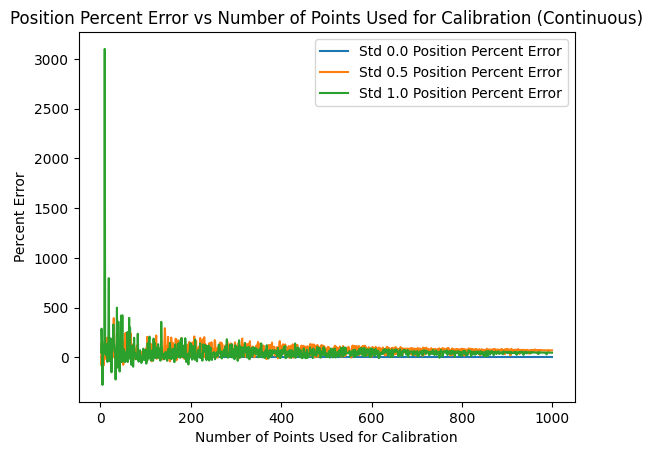

In [16]:
for std, arrays, _ in calibrations_by_stds[:3]:
    percent_error = (np.array(arrays) - np.tile(laser_params, (len(arrays), 1))) / np.tile(laser_params, (len(arrays), 1))

    direction_percent_error = percent_error[:, ][:, 0:3]
    position_percent_error = np.mean(percent_error[:, ][:, 3:5], axis=1)

    plt.plot(np.arange(2, STEP_COUNT), position_percent_error, label=f'Std {std} Position Percent Error')

plt.title('Position Percent Error vs Number of Points Used for Calibration (Continuous)')
plt.xlabel('Number of Points Used for Calibration')
plt.ylabel('Percent Error')
plt.legend()

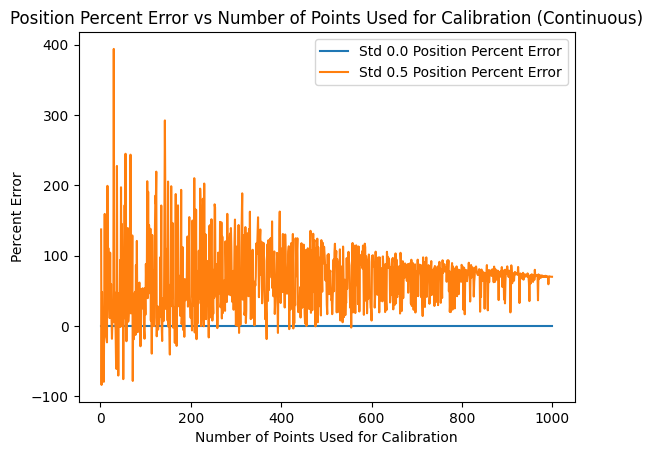

In [17]:
for std, arrays, _ in calibrations_by_stds[:2]:
    percent_error = (np.array(arrays) - np.tile(laser_params, (len(arrays), 1))) / np.tile(laser_params, (len(arrays), 1))

    direction_percent_error = percent_error[:, ][:, 0:3]
    position_percent_error = np.mean(percent_error[:, ][:, 3:5], axis=1)

    plt.plot(np.arange(2, STEP_COUNT), position_percent_error, label=f'Std {std} Position Percent Error')

plt.title('Position Percent Error vs Number of Points Used for Calibration (Continuous)')
plt.xlabel('Number of Points Used for Calibration')
plt.ylabel('Percent Error')
plt.legend()

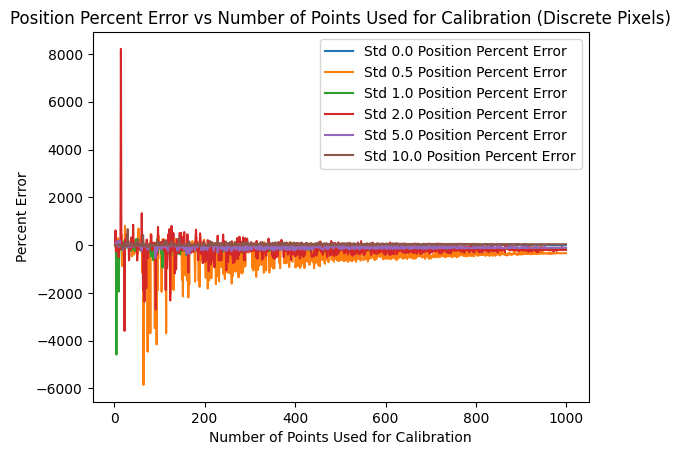

In [18]:
for std, _, arrays_pixel in calibrations_by_stds:
    percent_error = (np.array(arrays_pixel) - np.tile(laser_params, (len(arrays_pixel), 1))) / np.tile(laser_params, (len(arrays_pixel), 1))

    direction_percent_error = percent_error[:, ][:, 0:3]
    position_percent_error = np.mean(percent_error[:, ][:, 3:5], axis=1)

    plt.plot(np.arange(2, STEP_COUNT), position_percent_error, label=f'Std {std} Position Percent Error')

plt.title('Position Percent Error vs Number of Points Used for Calibration (Discrete Pixels)')
plt.xlabel('Number of Points Used for Calibration')
plt.ylabel('Percent Error')
plt.legend()

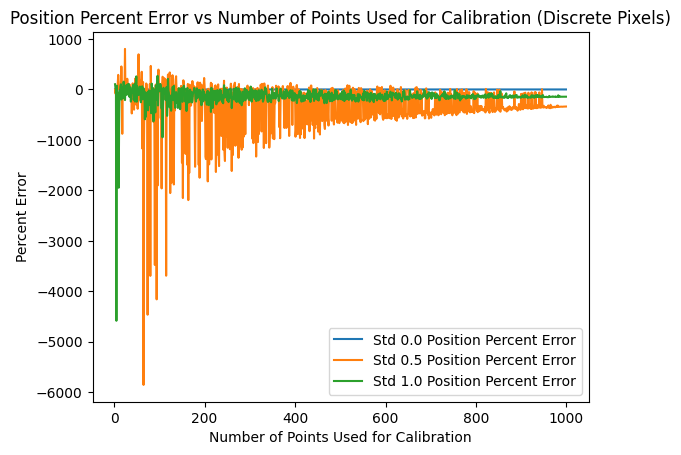

In [19]:
for std, _, arrays_pixel in calibrations_by_stds[:3]:
    percent_error = (np.array(arrays_pixel) - np.tile(laser_params, (len(arrays_pixel), 1))) / np.tile(laser_params, (len(arrays_pixel), 1))

    direction_percent_error = percent_error[:, ][:, 0:3]
    position_percent_error = np.mean(percent_error[:, ][:, 3:5], axis=1)

    plt.plot(np.arange(2, STEP_COUNT), position_percent_error, label=f'Std {std} Position Percent Error')

plt.title('Position Percent Error vs Number of Points Used for Calibration (Discrete Pixels)')
plt.xlabel('Number of Points Used for Calibration')
plt.ylabel('Percent Error')
plt.legend()

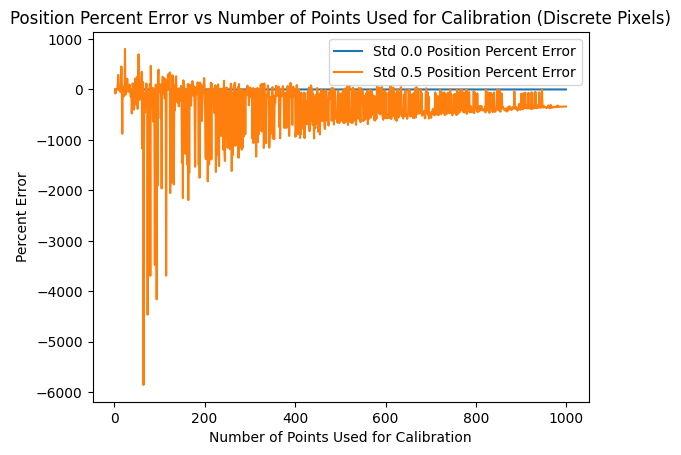

In [20]:
for std, _, arrays_pixel in calibrations_by_stds[:2]:
    percent_error = (np.array(arrays_pixel) - np.tile(laser_params, (len(arrays_pixel), 1))) / np.tile(laser_params, (len(arrays_pixel), 1))

    direction_percent_error = percent_error[:, ][:, 0:3]
    position_percent_error = np.mean(percent_error[:, ][:, 3:5], axis=1)

    plt.plot(np.arange(2, STEP_COUNT), position_percent_error, label=f'Std {std} Position Percent Error')

plt.title('Position Percent Error vs Number of Points Used for Calibration (Discrete Pixels)')
plt.xlabel('Number of Points Used for Calibration')
plt.ylabel('Percent Error')
plt.legend()

## Testing Each Calibration

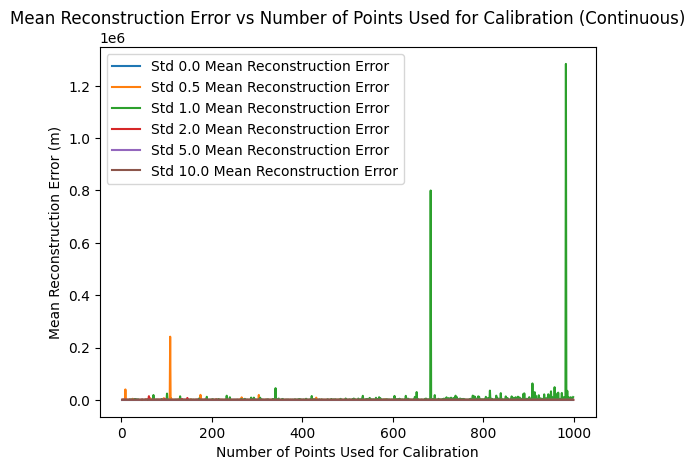

In [47]:
for std, arrays, _ in calibrations_by_stds:
    mean_errors = []
    for calibration in arrays:
        laser_axis = calibration[0:3]
        
        laser_origin = np.zeros((3,))
        laser_origin[0:2] = calibration[3:5]
        laser_origin[2] = 0.0

        projected_points = inverted_camera_intrinsics @ s
        norms = np.linalg.norm(projected_points, axis=0)
        final_laser_axis = -projected_points / norms

        point_constants = (
				(final_laser_axis.T @ laser_origin)
			 	- (laser_axis.T @ laser_origin) * (laser_axis.T @ final_laser_axis)
			) / (1 - (laser_axis.T @ final_laser_axis) ** 2)
        world_points = np.tile(point_constants, (3, 1)) * final_laser_axis
        mean_error = np.sqrt(np.mean(np.sum((world_points - p) ** 2, axis=1)))

        mean_errors.append(mean_error)

    plt.plot(np.arange(2, STEP_COUNT), mean_errors, label=f'Std {std} Mean Reconstruction Error')

plt.title('Mean Reconstruction Error vs Number of Points Used for Calibration (Continuous)')
plt.xlabel('Number of Points Used for Calibration')
plt.ylabel('Mean Reconstruction Error (m)')
plt.legend()

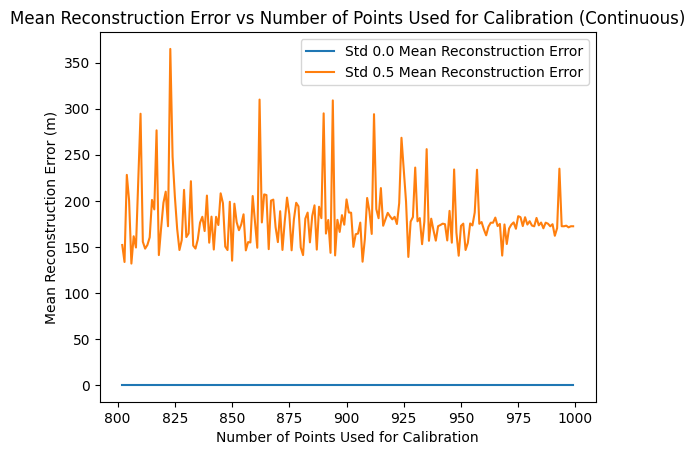

In [52]:
for std, arrays, _ in calibrations_by_stds[:2]:
    mean_errors = []
    for calibration in arrays:
        laser_axis = calibration[0:3]
        
        laser_origin = np.zeros((3,))
        laser_origin[0:2] = calibration[3:5]
        laser_origin[2] = 0.0

        projected_points = inverted_camera_intrinsics @ s
        norms = np.linalg.norm(projected_points, axis=0)
        final_laser_axis = -projected_points / norms

        point_constants = (
				(final_laser_axis.T @ laser_origin)
			 	- (laser_axis.T @ laser_origin) * (laser_axis.T @ final_laser_axis)
			) / (1 - (laser_axis.T @ final_laser_axis) ** 2)
        world_points = np.tile(point_constants, (3, 1)) * final_laser_axis
        mean_error = np.sqrt(np.mean(np.sum((world_points - p) ** 2, axis=1)))

        mean_errors.append(mean_error)

    plt.plot(np.arange(2, STEP_COUNT)[800:], mean_errors[800:], label=f'Std {std} Mean Reconstruction Error')

plt.title('Mean Reconstruction Error vs Number of Points Used for Calibration (Continuous)')
plt.xlabel('Number of Points Used for Calibration')
plt.ylabel('Mean Reconstruction Error (m)')
plt.legend()

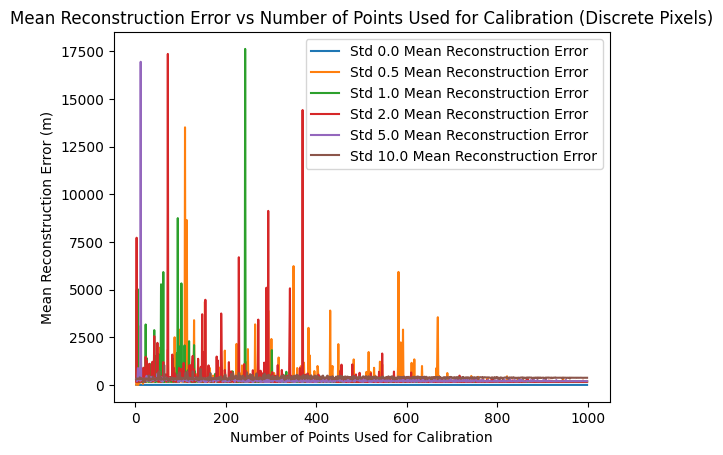

In [53]:
for std, _, arrays in calibrations_by_stds:
    mean_errors = []
    for calibration in arrays:
        laser_axis = calibration[0:3]
        
        laser_origin = np.zeros((3,))
        laser_origin[0:2] = calibration[3:5]
        laser_origin[2] = 0.0

        projected_points = inverted_camera_intrinsics @ s
        norms = np.linalg.norm(projected_points, axis=0)
        final_laser_axis = -projected_points / norms

        point_constants = (
				(final_laser_axis.T @ laser_origin)
			 	- (laser_axis.T @ laser_origin) * (laser_axis.T @ final_laser_axis)
			) / (1 - (laser_axis.T @ final_laser_axis) ** 2)
        world_points = np.tile(point_constants, (3, 1)) * final_laser_axis
        mean_error = np.sqrt(np.mean(np.sum((world_points - p) ** 2, axis=1)))

        mean_errors.append(mean_error)

    plt.plot(np.arange(2, STEP_COUNT), mean_errors, label=f'Std {std} Mean Reconstruction Error')

plt.title('Mean Reconstruction Error vs Number of Points Used for Calibration (Discrete Pixels)')
plt.xlabel('Number of Points Used for Calibration')
plt.ylabel('Mean Reconstruction Error (m)')
plt.legend()

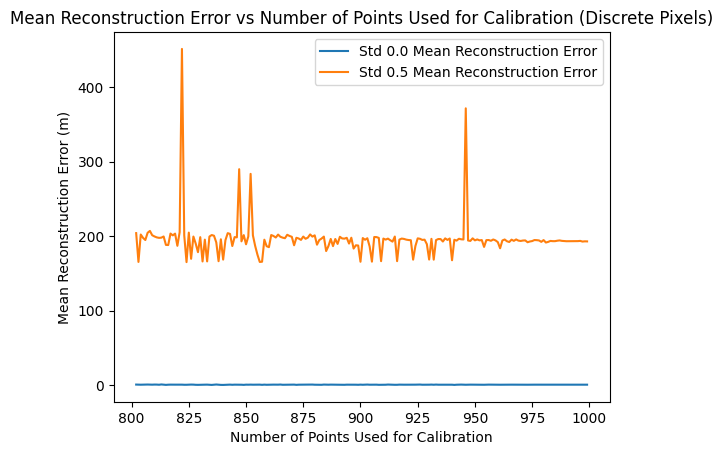

In [57]:
for std, _, arrays in calibrations_by_stds[:2]:
    mean_errors = []
    for calibration in arrays:
        laser_axis = calibration[0:3]
        
        laser_origin = np.zeros((3,))
        laser_origin[0:2] = calibration[3:5]
        laser_origin[2] = 0.0

        projected_points = inverted_camera_intrinsics @ s
        norms = np.linalg.norm(projected_points, axis=0)
        final_laser_axis = -projected_points / norms

        point_constants = (
				(final_laser_axis.T @ laser_origin)
			 	- (laser_axis.T @ laser_origin) * (laser_axis.T @ final_laser_axis)
			) / (1 - (laser_axis.T @ final_laser_axis) ** 2)
        world_points = np.tile(point_constants, (3, 1)) * final_laser_axis
        mean_error = np.sqrt(np.mean(np.sum((world_points - p) ** 2, axis=1)))

        mean_errors.append(mean_error)

    plt.plot(np.arange(2, STEP_COUNT)[800:], mean_errors[800:], label=f'Std {std} Mean Reconstruction Error')

plt.title('Mean Reconstruction Error vs Number of Points Used for Calibration (Discrete Pixels)')
plt.xlabel('Number of Points Used for Calibration')
plt.ylabel('Mean Reconstruction Error (m)')
plt.legend()